In [1]:
legend_utils_path = '/global/homes/f/fnafis/LEGEND/legend'
import sys
if legend_utils_path not in sys.path:
    sys.path.append(legend_utils_path)
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import pygama.math.histogram as pgh
import legend_utils as lu
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter
plt.style.use('~/KrSTC/data/physrev.mpl')

In [2]:
evt_filenames_vancouver = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_3.txt'
df = pd.DataFrame()
primaries = 0
with open(evt_filenames_list) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        ff = ur.open(evt_filename)
        print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        dets = np.concatenate(dets)
        primaries += len(dets)
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df = pd.concat([df, d], ignore_index=True)
   
print(primaries)
df['energy'] = df['energy'].apply(lambda x: x*1000)
df

/global/homes/f/fnafis/56Co_SIS2_neg376mm_test_with_one_gamma_2_evt.root opened
238691


,mage_id,energy
0,1010207,171.655067
1,1010208,2715.253099
2,1010207,2668.628302
3,1010106,500.485400
4,1010908,393.994396
...,...,...
238686,1010912,1761.342257
238687,1010810,196.755944
238688,1010809,192.603869
238689,1011013,2546.698963


732


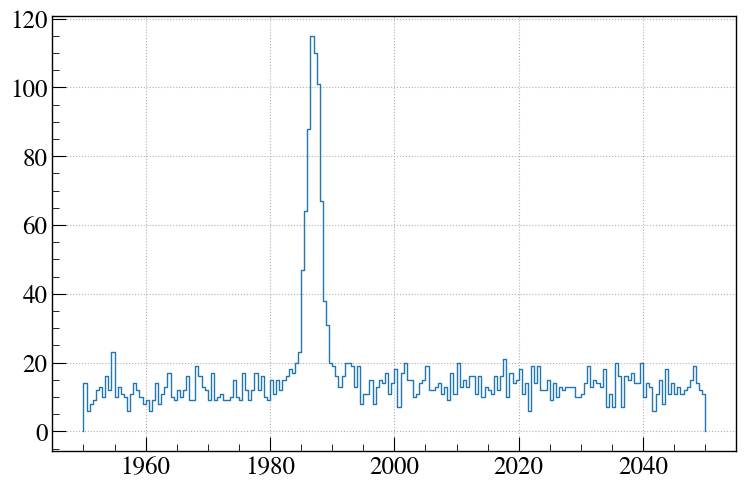

In [6]:
hv, bv, vv = pgh.get_hist(df['energy'], range=(1950, 2050), dx=0.5)
pgh.plot_hist(hv, bv, lw=1)
# get sum of hv where 1960<bv<1975
left_bkg = np.sum(hv[np.where((bv>1960) & (bv<1975))])
right_bkg = np.sum(hv[np.where((bv>2000) & (bv<2015))])
bkg = left_bkg + right_bkg
print(bkg)

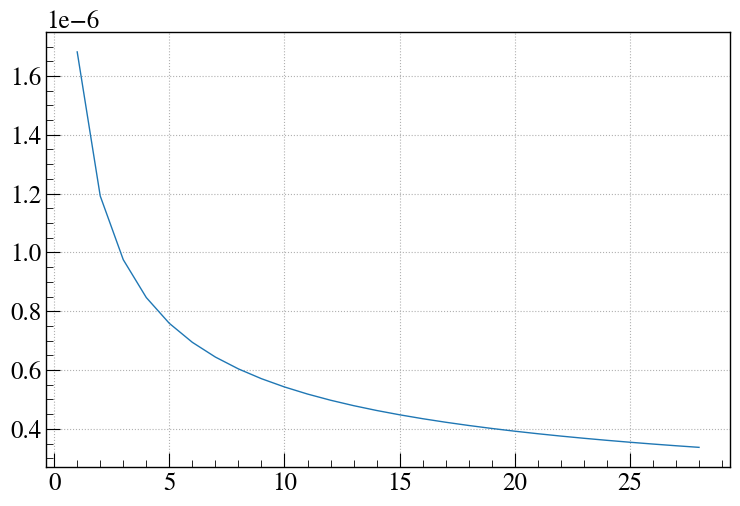

In [7]:
survival_frac_unc = 0.03
source_activity_Ci = 1 #uCi
source_activity_Bq = source_activity_Ci*3.7e10 #Bq
primaries = 100000
unc_0 = 0.03
N_Co = primaries/0.01

half_life = 77.236 # days
half_life = half_life*24*60*60 # seconds
decay_constant = np.log(2)/half_life # 1/s

days_elapsed = np.arange(1, 29, 1)
uncs = []
for d in days_elapsed:
    N = source_activity_Bq/decay_constant*(1-np.exp(-decay_constant*d*86400))
    unc = unc_0*np.sqrt(N_Co/N)
    uncs.append(unc)

plt.plot(days_elapsed, uncs, lw=1)



